# Понижение размерности данных (отбор признаков)

![](http://i.imgur.com/9HiVD0m.png)


Основная цель: каким-либо образом "уменьшить" число признаков.

Почему это может быть важно:

### Проклятие размерности

Рассмотрим пример (аналогично пончикам с лекции): пусть есть треугольники, круги и квадратики. Будем считать что признаки принимают значения только из какого-то интервала. Если есть всего один признак, то объекты лежат "примерно" рядом. В случае двух признаков они находятся дальше друг от друга. При увеличении размерности объекты будут все дальше друг от друга. То есть чем больше пространство, тем объекты становятся более "непохожими" (лежат далеко друг от друга). Получается, нужно много данных, чтобы алгоритм мог с ними работать (что порой затруднительно).

![](http://nikhilbuduma.com/img/dimension_sparsity.png)

### Шумовые и просто плохие признаки

Присутствие шума в признаках может ухудшать модель. Будем решать задачу классификации.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline

In [29]:
import sklearn.datasets
from sklearn.cross_validation import train_test_split

Рассмотрим некоторую случайную выборку, где все признаки "хорошие". Разделим ее на обучающую и тестовую:

In [30]:
X, y = sklearn.datasets.make_classification(n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

В качестве модели будем использовать логистическую регрессию. Для оценки качества воспользуемся метрикой *Accuracy*.

In [31]:
from sklearn.linear_model import LogisticRegressionCV

In [32]:
from sklearn.metrics import accuracy_score

Обучим нашу модель и посчитаем ее качество:

In [34]:
lr = LogisticRegressionCV(Cs=[0.01, 0.1, 1.0], random_state=42)
lr.fit(X_train, y_train)
accuracy_score(y_test, lr.predict(X_test))

0.940

Теперь к обучающим и тестовым данным добавим признак, не несущий никакой информации, а являющийся равномерным шумом на интервале от 0 до 1.

In [35]:
X_train_noise = np.concatenate([X_train, np.random.uniform(size=(X_train.shape[0], 1))], axis=1)
X_test_noise = np.concatenate([X_test, np.random.uniform(size=(X_test.shape[0], 1))], axis=1)

In [36]:
lr = LogisticRegressionCV(Cs=[0.01, 0.1, 1.0], random_state=42)
lr.fit(X_train_noise, y_train)
accuracy_score(y_test, lr.predict(X_test_noise))

0.920

Можно заметить, что качество стало чуть хуже.

Аналогично и для "плохих" признаков (в данном случае — коррелирующих). Добавим к исходным данным первый признак умноженый на 2.

In [37]:
X_train_corr = np.concatenate([X_train, (X_train[:,0] * 2)[:, np.newaxis]], axis=1)
X_test_corr = np.concatenate([X_test, (X_test[:, 0] * 2)[:, np.newaxis]], axis=1)

In [38]:
lr = LogisticRegressionCV(Cs=[0.01, 0.1, 1.0], random_state=42)
lr.fit(X_train_corr, y_train)
accuracy_score(y_test, lr.predict(X_test_corr))

0.920

Качество снова стало чуть ниже.

К сожалению, сходу не всегда понятно какие именно из признаков являются шумовыми.

### Переобучение

Чем больше признаков, тем сложнее становится модель (например, в случае линейных — нужно находить больше коэффициентов). Таким образом, если признаков очень много, а данных не совсем — можно столкнуться с переобучением.

*Какие еще проблемы возникают при большом числе признаков?*

## Отбор признаков

 - Одномерные методы — оценивают важность признаков по отдельности

Например, использую оценку дисперсии признака:

In [39]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [40]:
X = [[0, 0, 1], 
     [0, 1, 0], 
     [1, 0, 0], 
     [0, 1, 1], 
     [0, 1, 0], 
     [0, 1, 1]]
sel = VarianceThreshold()
sel.fit(X)
sel.variances_

array([ 0.139,  0.222,  0.25 ])

Теперь попробуем поработать с реальными данными.

Рассмотрим датасет Титаник:

In [41]:
data = pd.read_csv('titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Оставим только числовые признаки (а пол перекодируем в 0 и 1), выкинем объекты с пропусками:

In [42]:
X = data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
X['Sex'] = (data.Sex == 'male').astype('int')
X = X.dropna(axis=0)

y = data.Survived[X.index]

X.head()

/Users/yashakb/env-yashakb/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Pclass,Age,SibSp,Parch,Fare,Sex
0,3,22.0,1,0,7.2500,1
1,1,38.0,1,0,71.2833,0
2,3,26.0,0,0,7.9250,0
3,1,35.0,1,0,53.1000,0
4,3,35.0,0,0,8.0500,1


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Теперь посмотрим какие признаки с точки зрения одномерных методов важны.

Функция *SelectKBest* позволяет выбрать *k* наиболее важных признаков из модели с помощью заданного метода, после чего оставить только их. Так как в данном случае нам интересно скорее посмотреть на сами признаки, просто рассмотрим какие "важности" мы получаем, используя этот метод. 

In [44]:
selector = SelectKBest(f_classif, k=2)
selector.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_classif at 0x1127636e0>)

Посмотрим на полученные значения:

In [45]:
scores = selector.scores_
scores

array([  6.771e+01,   8.380e+00,   5.096e-03,   3.647e+00,   4.239e+01,
         2.354e+02])

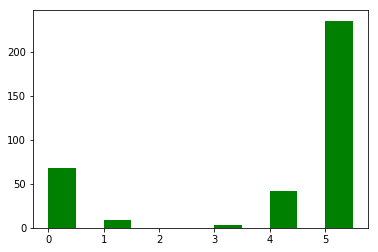

In [46]:
ind = np.arange(scores.size)
width = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(ind + width / 2, scores, width, color='g')

Итак, получили что пол, класс и цена билета хорошо связаны с целевой меткой (с точки зрения этого метода), в то время как SibSp имеет относительно малую значимость. Посмотрим, найдутся ли эти закономерности, если мы попробуем воспользоваться другой группой методов.

 - Отбор с помощью моделей
 
Некоторые изученные модели позволяют оценить "важность" признаков.

Например:
 - коэффициенты в линейных моделях можно интерпретировать как "важности" признаков в случае смасштабированных данных (а в случае *L1*-регуляризации коэффициенты при *неважных* признаках зануляются, например, в *Lasso*)
 - RandomForest (и просто решающее дерево) умеют оценивать насколько важен был признак
 
Попробуем понять, являются ли эти празнаки также важными с точки зрения моделей.

Для начала рассмотрим знакомую нам линейную модель (логистическую регрессию):

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

lr = LogisticRegressionCV(Cs=[0.1, 1.0, 10], random_state=42)
lr.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=[0.1, 1.0, 10], class_weight=None, cv=None,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=42, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [49]:
coef = lr.coef_
coef

array([[-1.026, -0.727, -0.337, -0.081,  0.111, -1.282]])

Построим коэффициенты на диаграмме для более удобного сравнения (в качестве "важности" считаем модуль коэффициента):

<a list of 6 Text xticklabel objects>

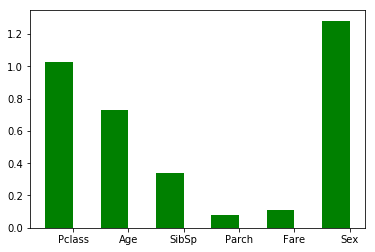

In [50]:
idx = np.arange(coef.size)
width = 0.5
p1 = plt.bar(idx, np.abs(coef[0]), width, color='g')
plt.xticks(idx + width/2, X.columns)[1]

И посмотрим на качество модели:

In [51]:
X_test_scaled = scaler.transform(X_test)
accuracy_score(y_test, lr.predict(X_test_scaled))

0.771

А теперь случайный лес:

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Теперь посчитаем важности признаков:

In [54]:
importance = rf.feature_importances_
importance

array([ 0.089,  0.303,  0.044,  0.036,  0.268,  0.26 ])

В данном случае само значение важности не несет какой-то глубокой информации (кроме как чем больше — тем лучше), оно скорее важно для сравнения признаков между собой.

<a list of 6 Text xticklabel objects>

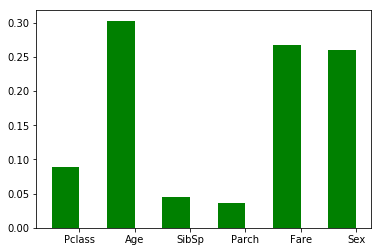

In [55]:
idx = np.arange(importance.size)
width = 0.5
p1 = plt.bar(idx, importance, width, color='g')
plt.xticks(idx + width/2, X.columns)[1]

Вполне логично, что возраст, пол и цена билета (которая неявно указывает на класс пассажира) важны в этой задаче.

In [56]:
accuracy_score(y_test, rf.predict(X_test))

0.782

Если сравнивать с предыдущим методом отбора признаков, то можно сказать что модели также находят указанные закономерности в данных.

Обе модели показали сравнимое качество, но в тоже время выбрали разные "важные признаки". Так как модели имеют разную природу, следовательно влияние признаков вычисляется по-разному. Это необходимо помнить, но также уметь сравнивать результаты: по обеим моделям явно видно, что возраст, как и пол, достаточно хорошие признаки. В то же время цена билета явно зависела от класса, поэтому это нормально что одна модель обратила внимание на цену, а другая — на класс.

## Principal Component Analysis (PCA)

**Метод главных компонент** (Principal Component Analysis, PCA) — метод понижения размерности данных путем проецирования в пространство меньшей размерности при помощи линейного преобразования, т.е.:

$$ z_{ij} = \sum_{k=1}^{D} w_{jk}x_{ik}$$

где 
 - $x_{ik}$ — старые признаки ($D$ штук)
 - $w_{jk}$ — вес старого признака $k$ в новом $j$-ом признаке
 - $z_{ij}$ — новые признаки ($d$ штук, $d$ меньше чем $D$)

Таким образом, вместо $D$ исходных признаков получаем $d < D$ новых признаков, которые являются линейными комбинациями исходных (каждый столбец новой матрицы $Z$ — линейная комбинация столбцов матрицы $X$).

Метод главных компонент, атким образом, является методов **извлечения** признаков.

Основная идея: необходимо спроецировать данные на некоторую гиперплоскость, при этом дисперсия выборки после проецирования должна оказаться как можно выше.

In [57]:
import matplotlib.pylab as plt

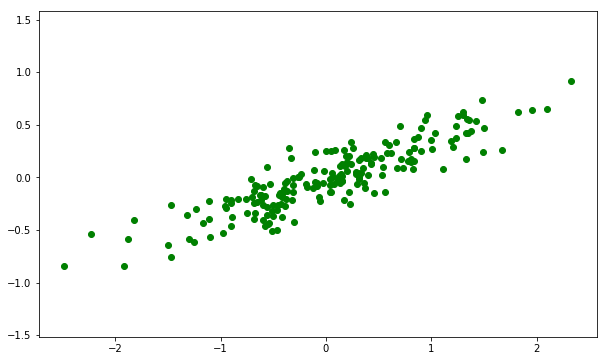

In [58]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.figure(figsize=(10, 6))
plt.plot(X[:, 0], X[:, 1], 'og')
plt.axis('equal');

Можно заметить, что в данных есть определенный "тренд". *PCA* пытается найти **главные оси**:

![](https://i.ytimg.com/vi/BfTMmoDFXyE/hqdefault.jpg)

Обучим для двумерного случая:

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, n_components=2, whiten=False)

Посмотрим сколько информации (то есть какую долю дисперсии) несет каждая компонента:

In [61]:
pca.explained_variance_ratio_

array([ 0.976,  0.024])

Видно, что почти вся информация заключена в 1 компоненте.

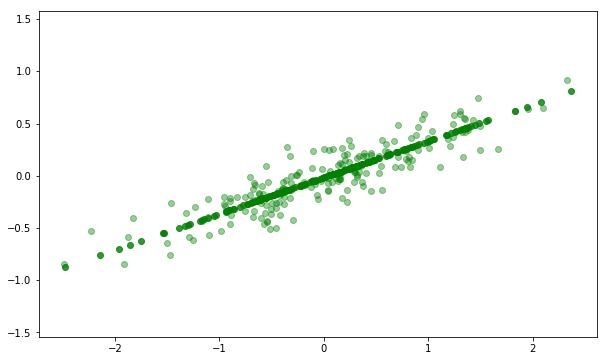

In [62]:
pca = PCA(n_components=1)
X_trans = pca.fit_transform(X)
X_new = pca.inverse_transform(X_trans)

plt.figure(figsize=(10, 6))
plt.plot(X[:, 0], X[:, 1], 'og', alpha=0.4)
plt.plot(X_new[:, 0], X_new[:, 1], 'og', alpha=0.8)
plt.axis('equal');

Само преобразование будет следующим:

In [63]:
pca.components_

array([[ 0.944,  0.329]])

Чем удобно PCA? Оно дает возможность работать с данными большой размерности! То есть если выбранный метод плохо работает в случае большого числа признаков, вы можете их "сжать", после чего работать с полученным представлением.

Но не стоит забывать и про визуализацию! Например, вспомним ирисы Фишера. Это небольшой датасет с 4 признаками, про этом визуализировать все 4 одновременно не удастся, к сожалению. Выход: с помощью PCA перейти в двумерное пространство.

In [65]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/yashakb/env-yashakb/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


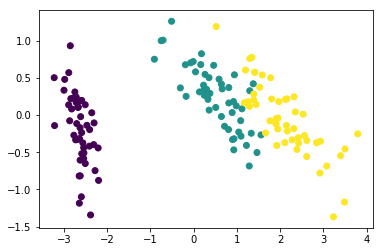

In [70]:
figsize(6,4)
from sklearn import datasets

iris = datasets.load_iris()
X_reduced = PCA(n_components=2).fit_transform(iris.data)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=iris.target)

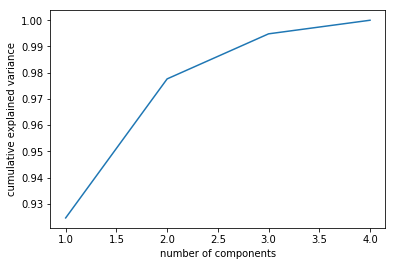

In [71]:
pca = PCA(n_components=4).fit(iris.data)
plt.plot(range(1, 5), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [72]:
pca.explained_variance_ratio_

array([ 0.925,  0.053,  0.017,  0.005])